In [36]:
# files loading
import os

from random import shuffle
import numpy as np

from tqdm import tqdm # progress bar

In [37]:
# image pretreatment
import matplotlib.pyplot as plt

import cv2
import numpy as np

from PIL import Image

In [38]:
# libraries for a CNN
import tensorflow as tf
from tensorflow import keras


from tensorflow.keras.models import Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense

import timeit

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    # Restrict TensorFlow to only allocate 1GB * 2 of memory on the first GPU
    try:
        tf.config.experimental.set_virtual_device_configuration(
            gpus[0],
            [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024 * 3)])
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

device_name = tf.test.gpu_device_name()
if "GPU" not in device_name:
    print("GPU device not found")
print('Found GPU at: {}'.format(device_name))

1 Physical GPUs, 1 Logical GPUs
Found GPU at: /device:GPU:0


In [39]:
from tensorflow import keras
from numpy import expand_dims
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

In [40]:
import imageio
import imgaug as ia
from imgaug import augmenters as iaa
# 

In [41]:
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model

In [42]:
ANNOTATION_DIR = 'Annotation' 
IMAGES_DIR = 'Images'

In [43]:
breed_list = os.listdir(IMAGES_DIR)
print("num. breeds total:", len(breed_list))

num. breeds total: 96


In [44]:
#récupération des races
filtered_breeds = [breed.split('-',1)[1] for breed in breed_list] #visualize breeds
filtered_breeds[:120]

['English_foxhound',
 'otterhound',
 'Scottish_deerhound',
 'Weimaraner',
 'Staffordshire_bullterrier',
 'American_Staffordshire_terrier',
 'Bedlington_terrier',
 'Border_terrier',
 'Kerry_blue_terrier',
 'Irish_terrier',
 'Norfolk_terrier',
 'Norwich_terrier',
 'Yorkshire_terrier',
 'wire-haired_fox_terrier',
 'Lakeland_terrier',
 'Sealyham_terrier',
 'Airedale',
 'cairn',
 'Australian_terrier',
 'Dandie_Dinmont',
 'Boston_bull',
 'miniature_schnauzer',
 'giant_schnauzer',
 'standard_schnauzer',
 'Scotch_terrier',
 'Tibetan_terrier',
 'silky_terrier',
 'soft-coated_wheaten_terrier',
 'West_Highland_white_terrier',
 'Lhasa',
 'flat-coated_retriever',
 'curly-coated_retriever',
 'golden_retriever',
 'Labrador_retriever',
 'Chesapeake_Bay_retriever',
 'German_short-haired_pointer',
 'vizsla',
 'English_setter',
 'Irish_setter',
 'Gordon_setter',
 'Brittany_spaniel',
 'clumber',
 'English_springer',
 'Welsh_springer_spaniel',
 'cocker_spaniel',
 'Sussex_spaniel',
 'Irish_water_spaniel',
 

n02096585-Boston_bull


C:\Users\Tetef\anaconda3\envs\GPUEnv\lib\site-packages\ipykernel_launcher.py:7: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  import sys


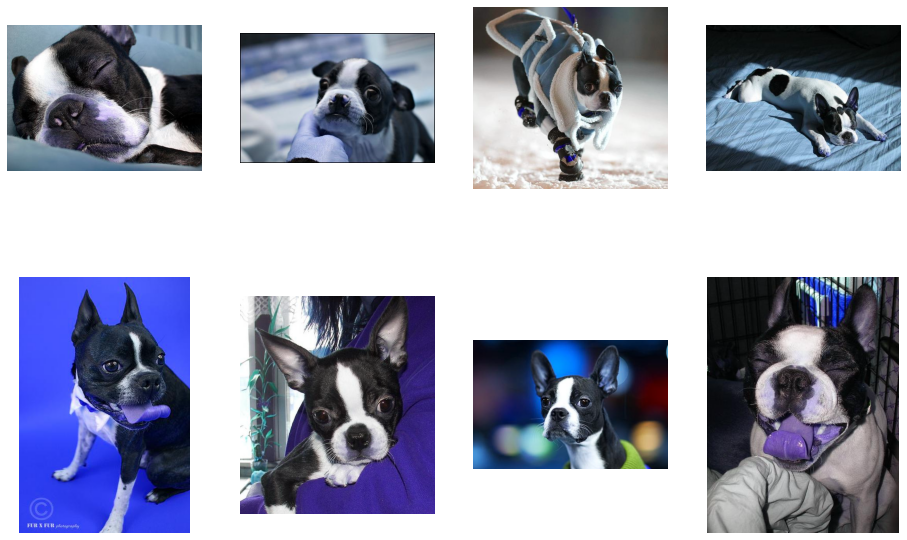

In [45]:
def show_dir_images(breed, n_to_show):
    plt.figure(figsize=(16,16))
    img_dir = "Images/{}/".format(breed)
    images = os.listdir(img_dir)[:n_to_show]
    for i in range(n_to_show):
        img = cv2.imread(img_dir + images[i])
        plt.subplot(n_to_show/4+1, 4, i+1)
        plt.imshow(img)
        plt.axis('off')



print(breed_list[20])
show_dir_images(breed_list[20], 8)

In [46]:
#image=Image.open('images/Images/n02085620-Chihuahua/n02085620_275.jpg')
#image=image.convert('L')
#image=np.array(image)
#plt.imshow(image)

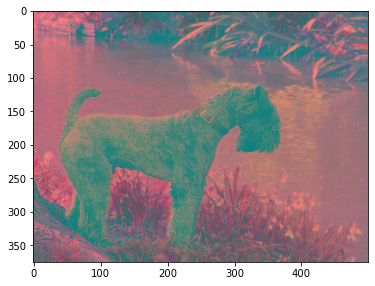

In [47]:
img_dir = "Images/{}/".format(breed_list[8])
images = os.listdir(img_dir)[:8]
images = os.listdir(img_dir)[:8]
img = cv2.imread(img_dir + images[0])

# transform image for equalization
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
img_grayscale = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
img_to_yuv = cv2.cvtColor(img,cv2.COLOR_BGR2YUV)

plt.imshow(img_to_yuv)

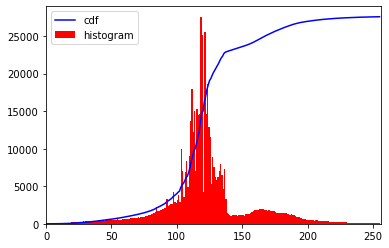

In [14]:
hist,bins = np.histogram(img_to_yuv.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(img_to_yuv.flatten(),256,[0,256], color = 'r')
plt.xlim([0,256])
plt.legend(('cdf','histogram'), loc = 'upper left')
plt.show()

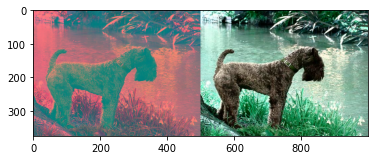

In [15]:
img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0])
equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2BGR)
res = np.hstack((img_to_yuv,equ)) #stacking images side-by-side
cv2.imwrite('res.png',res)
plt.imshow(res)

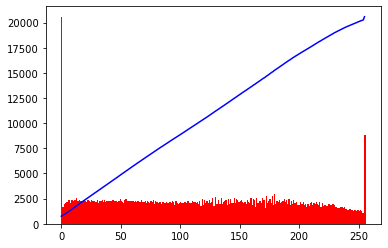

In [16]:
hist,bins = np.histogram(equ.flatten(),256,[0,256])
cdf = hist.cumsum()
cdf_normalized = cdf * float(hist.max()) / cdf.max()
plt.plot(cdf_normalized, color = 'b')
plt.hist(equ.flatten(),256,[0,256], color = 'r')
plt.show()

Augmented by rotation:


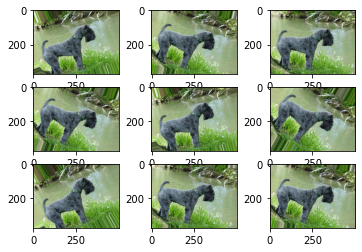

<Figure size 720x720 with 0 Axes>

In [17]:
print("Augmented by rotation:")
#ia.imshow(image_aug_2)
# convert to numpy array
data = img_to_array(img_RGB)

# expand dimension to one sample
samples = expand_dims(data, 0)
# create image data augmentation generator
datagen = ImageDataGenerator(rotation_range=30)
# prepare iterator
it = datagen.flow(samples, batch_size=1)
# generate samples and plot
for i in range(9):
    # define subplot
    plt.subplot(330 + 1 + i)
    # generate batch of images
    batch = it.next()
    # convert to unsigned integers for viewing
    image = batch[0].astype('uint8')
    # plot raw pixel data
    plt.imshow(image)
# show the figure
plt.figure(figsize = (10,10))
plt.show()

In [48]:
num_breeds = 50 # integer between 2 and 120 
breeds = breed_list[:num_breeds]

def load_images_and_labels(breeds):
    img_lst=[]
    labels=[]
    for index, breed in enumerate(breeds):
        for image_name in os.listdir(IMAGES_DIR+"/"+breed):
            img = cv2.imread(IMAGES_DIR+"/"+breed+"/"+image_name)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            img_to_yuv[:,:,0] = cv2.equalizeHist(img_to_yuv[:,:,0]) # convert to yuv color space for equalization
            equ = cv2.cvtColor(img_to_yuv, cv2.COLOR_YUV2RGB) # equalize
            
            img_array = Image.fromarray(img, 'RGB')
            
            #Redimensionnement image à 299 x 299
            resized_img = img_array.resize((299, 299))
            
            img_lst.append(np.array(resized_img))
            
            labels.append(index)
    return img_lst, labels

images, labels = load_images_and_labels(breeds)
print("No. of images loaded = ",len(images),"\nNo. of labels loaded = ",len(labels))
print(type(images),type(labels))

No. of images loaded =  8189 
No. of labels loaded =  8189
<class 'list'> <class 'list'>


In [49]:
images = np.array(images)
labels = np.array(labels)
#shuffle
print("Images shape = ",images.shape,"\nLabels shape = ",labels.shape)
print(type(images),type(labels))

Images shape =  (8189, 299, 299, 3) 
Labels shape =  (8189,)
<class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [50]:
#étape 1 
n = np.arange(images.shape[0])
print("10 valeurs de 'n' avant mélange = ",n[:10])

#mélange des valeurs 'n'
np.random.seed(42)
np.random.shuffle(n)
print("10 valeurs de 'n' après mélange = ",n[:10])

10 valeurs de 'n' avant mélange =  [0 1 2 3 4 5 6 7 8 9]
10 valeurs de 'n' après mélange =  [2126 4270 4894 6690 1320 5882 2835 5140 7656 7243]


In [51]:
#step 2 - shuffle images and corresponding labels data in both the lists
images = images[n]
labels = labels[n]

print("Images shape après le mélange = ",images.shape,"\nLabels shape après le mélange = ",labels.shape)
print('même shapes avant et après le mélange')

Images shape après le mélange =  (8189, 299, 299, 3) 
Labels shape après le mélange =  (8189,)
même shapes avant et après le mélange


In [52]:
#normalization
images = images.astype(np.float32)
labels = labels.astype(np.int32)
images = images/255

In [53]:
#split des images de train et tests
x_train, x_test, y_train, y_test = train_test_split(images, labels, test_size = 0.2, random_state = 42)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.1, random_state=1)

print("x_train shape = ",x_train.shape)
print("y_train shape = ",y_train.shape)

print("\nx_val shape = ",x_val.shape)
print("y_val shape = ",y_val.shape)

print("\nx_test shape = ",x_test.shape)
print("y_test shape = ",y_test.shape)

x_train shape =  (5895, 299, 299, 3)
y_train shape =  (5895,)

x_val shape =  (656, 299, 299, 3)
y_val shape =  (656,)

x_test shape =  (1638, 299, 299, 3)
y_test shape =  (1638,)


In [54]:
datagen = ImageDataGenerator(
        rotation_range=30,
        horizontal_flip=True,
        fill_mode='nearest')

# fit parameters from data
datagen.fit(x_train, augment=True)

In [55]:
model = Sequential()
# layer 1
model.add(Conv2D(16, (3, 3), padding='same', use_bias=False, input_shape=(299, 299, 3)))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 2
model.add(Conv2D(32, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 3
model.add(Conv2D(64, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(4, 4), strides=(4, 4), padding='same'))
model.add(Dropout(0.2))
# layer 4
model.add(Conv2D(128, (3, 3), padding='same', use_bias=False))
model.add(BatchNormalization(axis=3, scale=False))
model.add(Activation("relu"))
model.add(Flatten())
model.add(Dropout(0.2))
# fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dense(120, activation='softmax'))
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_8 (Conv2D)            (None, 299, 299, 16)      432       
_________________________________________________________________
batch_normalization_8 (Batch (None, 299, 299, 16)      48        
_________________________________________________________________
activation_8 (Activation)    (None, 299, 299, 16)      0         
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 75, 75, 16)        0         
_________________________________________________________________
dropout_8 (Dropout)          (None, 75, 75, 16)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 75, 75, 32)        4608      
_________________________________________________________________
batch_normalization_9 (Batch (None, 75, 75, 32)       

In [56]:
#compilation du réseau
model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(model.optimizer.learning_rate, 0.0015)

In [57]:
#arrêter le modéle si il fait du sur apprentissage
from tensorflow.keras.callbacks import EarlyStopping
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=5,
    verbose=1,
    mode='auto'
)
callbacks = [earlystop]

In [59]:
%%time
history =model.fit(x_train, y_train, validation_data = (x_val,y_val), epochs=20, callbacks = callbacks)

Epoch 1/20
185/185 [==============================] - 11s 49ms/step - loss: 3.4771 - accuracy: 0.0882 - val_loss: 3.6875 - val_accuracy: 0.0549
Epoch 2/20
185/185 [==============================] - 8s 44ms/step - loss: 3.3091 - accuracy: 0.1138 - val_loss: 3.3868 - val_accuracy: 0.1082
Epoch 3/20
185/185 [==============================] - 8s 44ms/step - loss: 3.1909 - accuracy: 0.1399 - val_loss: 3.5004 - val_accuracy: 0.0747
Epoch 4/20
185/185 [==============================] - 8s 44ms/step - loss: 3.1045 - accuracy: 0.1581 - val_loss: 3.7619 - val_accuracy: 0.0716
Epoch 5/20
185/185 [==============================] - 8s 44ms/step - loss: 3.0154 - accuracy: 0.1822 - val_loss: 3.3236 - val_accuracy: 0.1204
Epoch 6/20
185/185 [==============================] - 8s 44ms/step - loss: 2.9319 - accuracy: 0.1959 - val_loss: 3.2064 - val_accuracy: 0.1540
Epoch 7/20
185/185 [==============================] - 8s 44ms/step - loss: 2.8339 - accuracy: 0.2127 - val_loss: 3.2798 - val_accuracy: 0.152

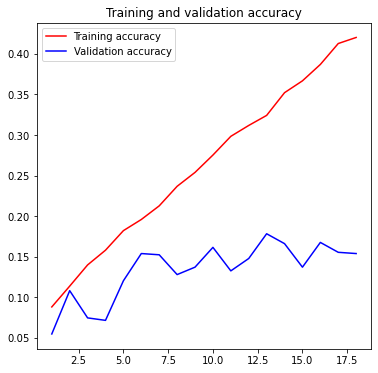

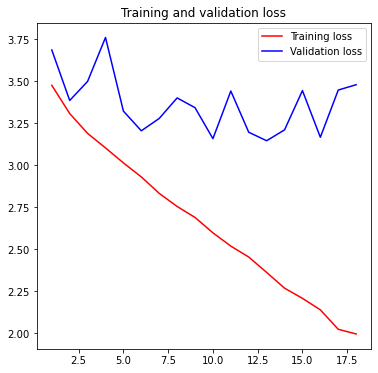

In [60]:
plt.rcParams['figure.figsize'] = (6,6)



acc = history.history['accuracy']

val_acc = history.history['val_accuracy']

loss = history.history['loss']

val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)



plt.title('Training and validation accuracy')

plt.plot(epochs, acc, 'red', label='Training accuracy')

plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')

plt.legend()



plt.figure()

plt.title('Training and validation loss')

plt.plot(epochs, loss, 'red', label='Training loss')

plt.plot(epochs, val_loss, 'blue', label='Validation loss')



plt.legend()



plt.show()

In [61]:
#evaluation du model
loss, accuracy = model.evaluate(x_test, y_test)

print(loss,accuracy)

52/52 [==============================] - 10s 146ms/step - loss: 3.4315 - accuracy: 0.1709
3.4315004348754883 0.17094017565250397


In [62]:
pred = model.predict(x_test)

pred.shape

(1638, 120)

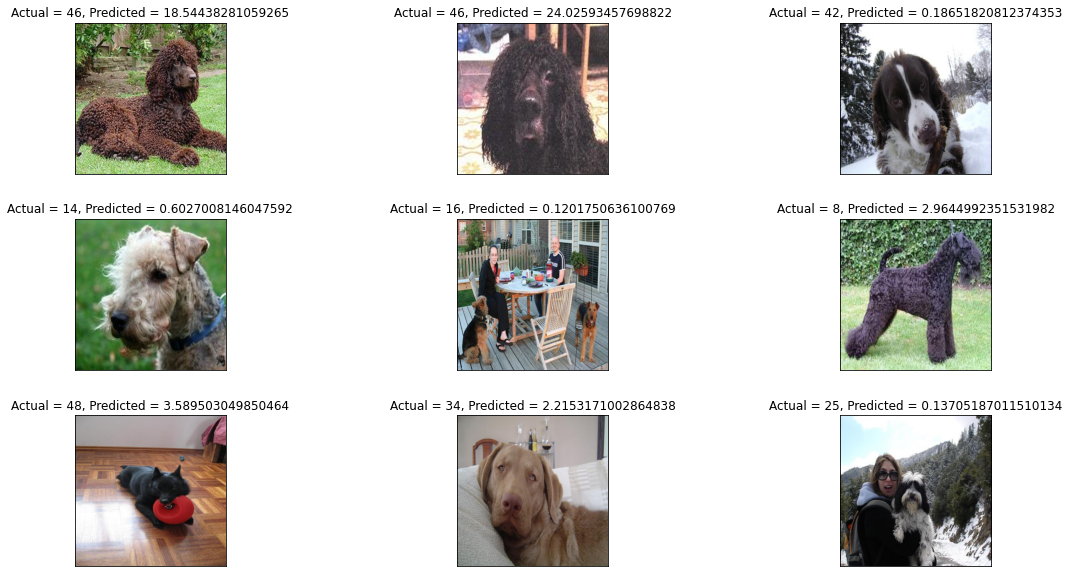

In [63]:
plt.figure(1 , figsize = (19 , 10))
n = 0 

for i in range(9):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(3, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , y_test[r[0]]*pred[r[0]][y_test[r[0]]]) )
    plt.xticks([]) , plt.yticks([])

plt.show()

In [65]:
#transfert learning
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import applications
from keras.layers import GlobalAveragePooling2D
InceptionV3 = applications.InceptionV3(include_top= False, input_shape= (299, 299, 3), weights= 'imagenet')
model2 = Sequential()

for layer in InceptionV3.layers:
    layer.trainable= False

model2.add(InceptionV3)
model2.add(GlobalAveragePooling2D())
model2.add(Dropout(0.2))

# Ajout de la dernière couche avec num_classes (trainable=true)
model2.add(Dense(120,activation='softmax'))
model2.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Functional)    (None, 8, 8, 2048)        21802784  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 2048)              0         
_________________________________________________________________
dense_7 (Dense)              (None, 120)               245880    
Total params: 22,048,664
Trainable params: 245,880
Non-trainable params: 21,802,784
_________________________________________________________________


In [66]:
model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
K.set_value(model2.optimizer.learning_rate, 0.0015)

In [67]:
%%time
#with tf.device('/device:GPU:0'):
    #history = model.fit(aug.flow(x_train, y_train), validation_data=(x_val, y_val), epochs=30)
history2 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=30)

Epoch 1/30
185/185 [==============================] - 26s 109ms/step - loss: 1.6445 - accuracy: 0.6590 - val_loss: 0.3195 - val_accuracy: 0.8994
Epoch 2/30
185/185 [==============================] - 17s 92ms/step - loss: 0.2339 - accuracy: 0.9311 - val_loss: 0.2822 - val_accuracy: 0.9070
Epoch 3/30
185/185 [==============================] - 17s 93ms/step - loss: 0.1783 - accuracy: 0.9432 - val_loss: 0.2744 - val_accuracy: 0.9162
Epoch 4/30
185/185 [==============================] - 17s 92ms/step - loss: 0.1372 - accuracy: 0.9574 - val_loss: 0.2694 - val_accuracy: 0.9131
Epoch 5/30
185/185 [==============================] - 17s 92ms/step - loss: 0.1105 - accuracy: 0.9635 - val_loss: 0.2700 - val_accuracy: 0.9055
Epoch 6/30
185/185 [==============================] - 17s 92ms/step - loss: 0.1080 - accuracy: 0.9669 - val_loss: 0.2886 - val_accuracy: 0.9024
Epoch 7/30
185/185 [==============================] - 17s 92ms/step - loss: 0.0872 - accuracy: 0.9746 - val_loss: 0.2791 - val_accuracy

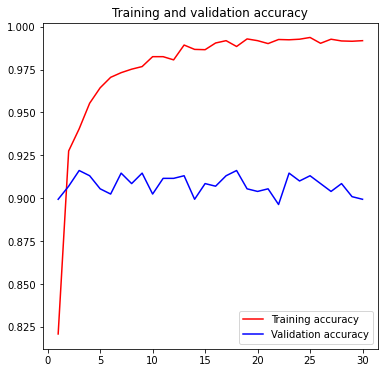

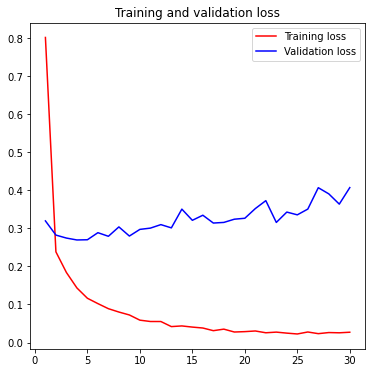

In [68]:
plt.rcParams['figure.figsize'] = (6,6)



acc = history2.history['accuracy']

val_acc = history2.history['val_accuracy']

loss = history2.history['loss']

val_loss = history2.history['val_loss']

epochs = range(1, len(acc) + 1)



plt.title('Training and validation accuracy')

plt.plot(epochs, acc, 'red', label='Training accuracy')

plt.plot(epochs, val_acc, 'blue', label='Validation accuracy')

plt.legend()



plt.figure()

plt.title('Training and validation loss')

plt.plot(epochs, loss, 'red', label='Training loss')

plt.plot(epochs, val_loss, 'blue', label='Validation loss')



plt.legend()



plt.show()

In [69]:
test_loss, test_accuracy = model2.evaluate(x_test, y_test)

print(test_loss,test_accuracy)

52/52 [==============================] - 6s 89ms/step - loss: 0.4150 - accuracy: 0.9151
0.4150129556655884 0.9151403903961182


In [70]:
pred2 = model2.predict(x_test)

pred2.shape

(1638, 120)

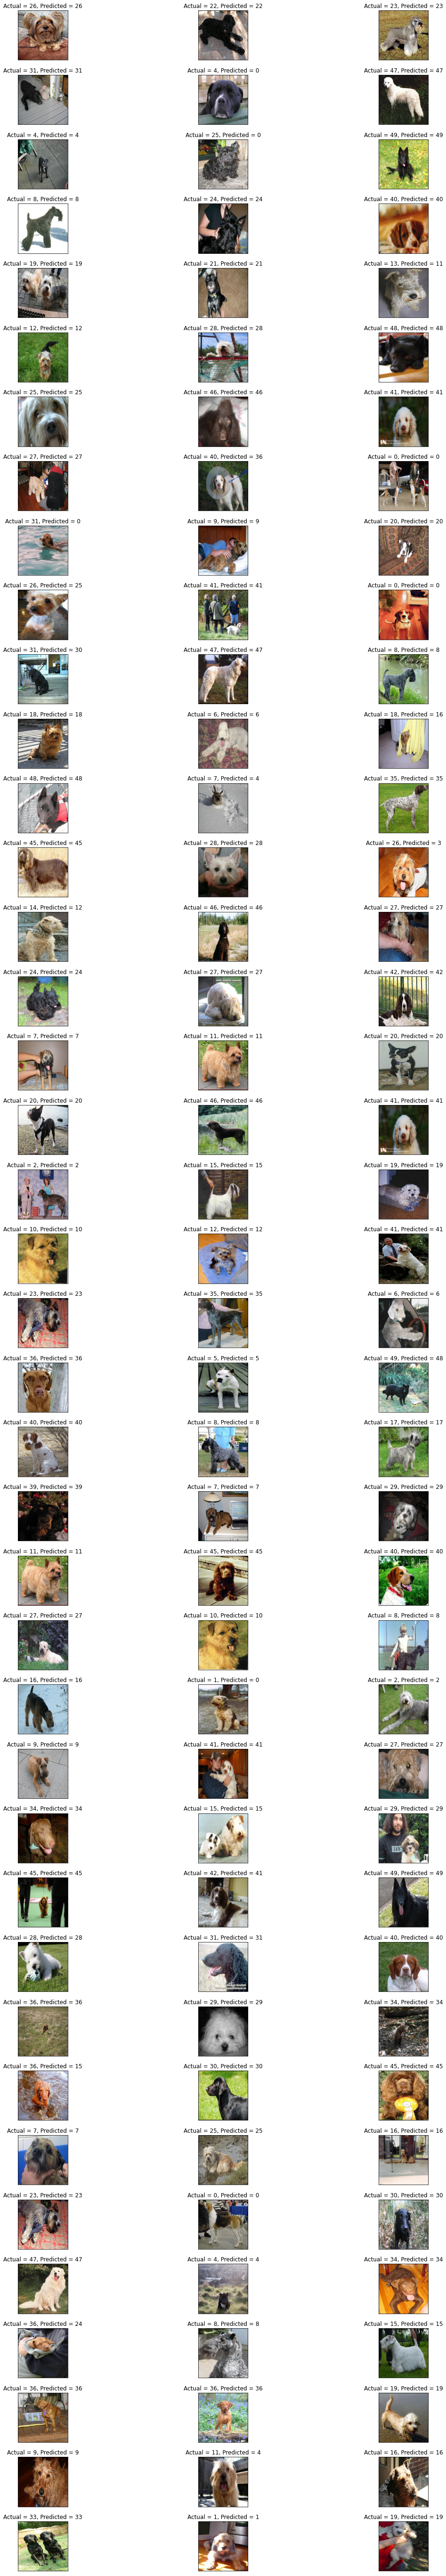

In [71]:
plt.figure(1 , figsize = (19 , 100))
n = 0 

for i in range(120):
    n += 1 
    r = np.random.randint( 0, x_test.shape[0], 1)
    
    plt.subplot(40, 3, n)
    plt.subplots_adjust(hspace = 0.3, wspace = 0.3)
    
    plt.imshow(x_test[r[0]])
    plt.title('Actual = {}, Predicted = {}'.format(y_test[r[0]] , round(y_test[r[0]]*pred2[r[0]][y_test[r[0]]])))
    plt.xticks([]) , plt.yticks([])

plt.show()